<a href="https://colab.research.google.com/github/naoya1110/DL_Lecture_202107/blob/main/Chapter06_MNIST_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 06: MNIST with CNN

Chapter 05では，ディープラーニングの最初の一歩として非常にシンプルなモデルを構築し学習させました。ここで使用したのは一次元のデータしか扱うことのできない全結合層（Dense Layer）だったため，もともと二次元配列の画像データを一次元配列に変更する必要がありました。実は，この方法ではピクセル間の位置の関係性が崩れてしまい画像データを取り扱う上で，あまり良い手段とは言えません。

この問題を解決するために，今日の画像認識においては畳み込み層（Convolutional Layer）と呼ばれる層を用いたモデル（Convolutional Neural Network）が使用されることがほとんどです。ここでは，簡単なCNNを構築して手書き数字の画像分類に取り組んでみましょう。

## 準備

### パッケージのインポート
基本的にはChapter 05と同じですが，```Conv2D```, ```MaxPooling2D```, ```Flatten```というモジュール（レイヤー）を新しく読み込みます。

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(precision=3,  suppress=True)
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.math import confusion_matrix

# trainX, trainYをさらに分離するために使用
from sklearn.model_selection import train_test_split

# TensorFlowのバージョンを確認
print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.5.0


### ランタイムの確認
ランタイムがGPUになっていることを確認しましょう。

## データの準備

### MNISTデータセットの読み込み
MNISTデータセットは
TensorFlowのコード1行でネット上から簡単に読み込むことができます。中身は以下の4種類になっています。

* **trainX** 学習用の入力データ
* **trainY** 学習用の出力データ
* **testX** テスト用の入力データ
* **testY** テスト用の出力データ

続けて，データの形やタイプを確認しておきましょう。

In [2]:
#自動的にネット上からデータがダウンロードする
(trainX, trainY), (testX, testY) = mnist.load_data()

# データの形とタイプを確認
print(f"trainX: Type {type(trainX)}, Shape {trainX.shape}")
print(f"trainY: Type {type(trainY)}, Shape {trainY.shape}")
print(f"testX: Type {type(testX)}, Shape {testX.shape}")
print(f"testY: Type {type(testY)}, Shape {testY.shape}")

11493376/11490434 [==============================] - 0s 0us/step
trainX: Type <class 'numpy.ndarray'>, Shape (60000, 28, 28)
trainY: Type <class 'numpy.ndarray'>, Shape (60000,)
testX: Type <class 'numpy.ndarray'>, Shape (10000, 28, 28)
testY: Type <class 'numpy.ndarray'>, Shape (10000,)


### 入力データ（trainX, testX）のフォーマットを変更する
今回構築するモデルは畳み込み層（Convolutional Layer）を使用するため，それに合うように入力データの次元を変更しておく必要が必要があります。```np.expand_dims()```というところで，次元を変更しています。また，すべての値を255で割ることで最大値が1.0, 最小値が0.0とする規格化も行っておきましょう。

In [3]:
# 畳み込み層に入力できるように次元を拡張する
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

#最大が1.0となるように規格化する
trainX = trainX/trainX.max()
testX = testX/testX.max()

#表示して確認する
print("---trainX---")
print("最大値：", trainX.max())
print("最小値：", trainX.min())
print("Shape：", trainX.shape)

print("\n---testX---")
print("最大値：", testX.max())
print("最小値：", testX.min())
print("Shape：", testX.shape)

---trainX---
最大値： 1.0
最小値： 0.0
Shape： (60000, 28, 28, 1)

---testX---
最大値： 1.0
最小値： 0.0
Shape： (10000, 28, 28, 1)


### 出力データ（trainY, testY）のフォーマットを変更する

出力データも学習に合うようにフォーマットを変更します。trainY, testYにはもともとtrainX, testXの画像データに対応する整数（0, 1, 2, 3, 4 ...）が入っていますが，これをOne-hotベクトルと呼ばれる以下のような長さが10の配列に変換します。例えば，もともとの数値が3であれば，3番目の要素が1でその他が0となっていることに注目してください。

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
4 -> [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
6 -> [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
7 -> [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
8 -> [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
9 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
```

In [4]:
# One-hotベクトルに変更する
trainY_onehot = to_categorical(trainY)
testY_onehot = to_categorical(testY)

# trainYの最初の5個を表示して確認
pd.DataFrame(trainY_onehot).head(5)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### validX, validYを生成
trainX, trainYを分離して検証用データ（validX, validY）を生成します。```test_size=0.2```とすれば，trainX, trainYの2割を検証用データとして使用することになります。

In [5]:
trainX, validX, trainY_onehot, validY_onehot = train_test_split(trainX, trainY_onehot, train_size=0.8)

### すべてのデータのshapeを確認
もう一度，念のためtrainX, trainY, validX, validY, testX, testYのshapeを確認しておきましょう。

In [6]:
# 念のため，trainX, trainY, testXのshapeを確認
print("shape")
print("trainX:", trainX.shape)
print("trainY_onehot:", trainY_onehot.shape)
print("validX:", validX.shape)
print("validY_onehot:", validY_onehot.shape)
print("testX shape:", testX.shape)
print("testY_onehot:", testY_onehot.shape)

shape
trainX: (48000, 28, 28, 1)
trainY_onehot: (48000, 10)
validX: (12000, 28, 28, 1)
validY_onehot: (12000, 10)
testX shape: (10000, 28, 28, 1)
testY_onehot: (10000, 10)


## 学習

### モデルの構築
ここでは畳み込み層を使ったモデル（CNN）を構築します。実際は二次元の畳み込み層（Conv2D）と二次元のプーリング層（MaxPooling2D），全結合層（Dense）が組み合わされています。

* **参考**　https://deepage.net/deep_learning/2016/11/07/convolutional_neural_network.html

In [7]:
# モデルの初期化
model = Sequential()

# 入力層
model.add(InputLayer(input_shape=(28,28,1)))

# 中間層（１層目），畳み込み層
model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))

# 中間層（2層目）プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 中間層（3層目），畳み込み層
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))

# 中間層（4層目），プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 中間層（5層目）, ここで三次元配列を一次元配列に変更
model.add(Flatten())


# 中間層（6層目），全結合層
model.add(Dense(units=32, activation="relu"))

# 出力層，全結合層
model.add(Dense(units=10, activation="softmax"))

# 構築したモデルを可視化して確認
# plot_model(model, show_shapes=True)

構築したモデルは次の方法でも確認できます。この方法では，学習させるパラメータの数を確認することもできます。

In [8]:
# 構築したモデルを別の方法で可視化して確認
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                50208     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

### モデルのコンパイル

モデルを学習させるためにコンパイルします。指定する主なパラメータは以下の通りです。

* **loss** 損失関数は何を使うか？分類問題の場合は，"categorical_crossentropy"がほとんど。
* **optimizer** 最適化関数は何を使うか？"adam"のほかに，"sgd", "RMSprop"などが使える
* **metrics** 評価関数。パラメータの最適化には用いられない。

In [9]:
# モデルをコンパイルする
model.compile(
                loss="categorical_crossentropy",
                optimizer="adam", 
                metrics=["accuracy"]
              )

### モデルの学習（トレーニング）

モデルを学習させます。```model.fit()```だけでも学習できますが，```history=model.fit()```としておくことで後から学習経過を可視化できます。指定する主なパラメータは以下の通りです。

* **trainX** 学習用データの入力データ
* **trainY** 学習用データの出力データ
* **batch_size** 何個のデータごとにパラメータを更新するか？1バッチあたりのデータ数
* **epochs** すべての学習用データを何回通りみるか？
* **validation_data** 検証用データ
* **shuffle** 学習用データを見る順番をシャッフルするか？
* **verbose** 学習経過の表示方法。0,1,2が選択可能。

In [10]:
history = model.fit(
                    trainX, trainY_onehot,
                    batch_size=64,
                    epochs=10,
                    validation_data=(validX, validY_onehot),
                    shuffle=True,
                    verbose=1
                   )

Epoch 1/10
750/750 [==============================] - 34s 4ms/step - loss: 0.2827 - accuracy: 0.9146 - val_loss: 0.0882 - val_accuracy: 0.9742
Epoch 2/10
750/750 [==============================] - 3s 4ms/step - loss: 0.0785 - accuracy: 0.9758 - val_loss: 0.0612 - val_accuracy: 0.9823
Epoch 3/10
750/750 [==============================] - 3s 4ms/step - loss: 0.0554 - accuracy: 0.9835 - val_loss: 0.0623 - val_accuracy: 0.9806
Epoch 4/10
750/750 [==============================] - 3s 4ms/step - loss: 0.0432 - accuracy: 0.9863 - val_loss: 0.0434 - val_accuracy: 0.9868
Epoch 5/10
750/750 [==============================] - 3s 4ms/step - loss: 0.0362 - accuracy: 0.9888 - val_loss: 0.0443 - val_accuracy: 0.9867
Epoch 6/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0292 - accuracy: 0.9910 - val_loss: 0.0408 - val_accuracy: 0.9872
Epoch 7/10
750/750 [==============================] - 3s 4ms/step - loss: 0.0239 - accuracy: 0.9926 - val_loss: 0.0424 - val_accuracy: 0.9878
Epoch

### 学習経過の確認
学習経過を可視化して上手く学習できているか，過学習などが起こっていないかを確認しましょう。

Text(0, 0.5, 'Accuracy & Loss')

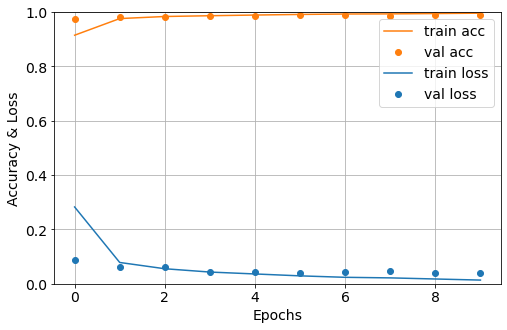

In [11]:
plt.figure(figsize=(8,5))
plt.rcParams["font.size"]=14

epoch = history.epoch
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.plot(epoch, train_acc, label="train acc", c="#ff7f0e")
plt.plot(epoch, val_acc, marker="o", lw=0, label="val acc", c="#ff7f0e")

plt.plot(epoch, train_loss, label="train loss", c="#1f77b4")
plt.plot(epoch, val_loss, marker="o", lw=0, label="val loss", c="#1f77b4")

plt.ylim(0, 1)
#plt.xlim(-10, 210)
plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Accuracy & Loss")

## 学習済みモデルの評価

### 学習済みモデルを使ってテスト用データ（testX）から数字を推論
次の1行でテスト用データに対して推論を行います。

In [12]:
# 推論
predY_onehot = model.predict(testX)

N番目のtestXに対する推論結果を確認してみましょう。推論結果の```predY```も長さが10の一次元配列になっています。

500番目の画像データに対する推論結果
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


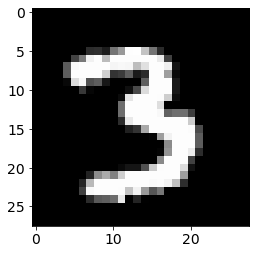

In [13]:
# N番目を指定
N = 500

# N番目の画像データを表示
plt.imshow(testX[N].reshape(28,28), cmap="gray")

# N番目の推論結果を表示
print(f"{N}番目の画像データに対する推論結果")
print(predY_onehot[N])

推論結果である```predY```の10個の数値は，それぞれ0~9の数字である確率を表していて，最も高い確率を示す要素の指標（順番）が元の画像データの数字だと言えます。以下のコードで```predY```から実際の数字を求めます。

In [14]:
# 推論結果（確率）が最大となる指標を求める
predY = np.argmax(predY_onehot, axis=1)

# N番目の数字を確認する
print(predY[N])

3


### 推論結果の一部を可視化
学習済みモデルを使ってtestXのデータから推論した結果の一部を表示してみましょう。trueが正解値，predが推論結果です。

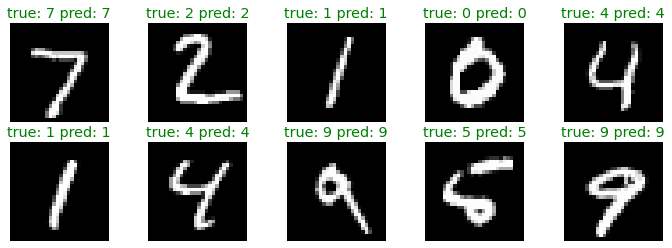

In [19]:
plt.figure(figsize=(12,4))
plt.rcParams["font.size"]=12

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(testX[i].reshape(28, 28), cmap='gray')
    plt.axis("off")
    true_index = testY[i]
    pred_index = predY[i]
    if true_index == pred_index:
        color = "green"
    else:
        color = "red"
    title = f"true: {true_index} pred: {pred_index}"
    plt.title(title, color=color)

### モデルの精度を検証
全てのテスト用データに対するモデルの精度を統計的に検証します。Chapter 05の結果と比べてみましょう。

In [20]:
score = model.evaluate(testX, testY_onehot)
print("Test Accuracy = {:.2f}".format(score[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.0328 - accuracy: 0.9899
Test Accuracy = 0.99


### 混同行列
モデルの精度をより詳しく検証するために混同行列を確認しましょう。

Text(0.5, 38.0, 'Prediction')

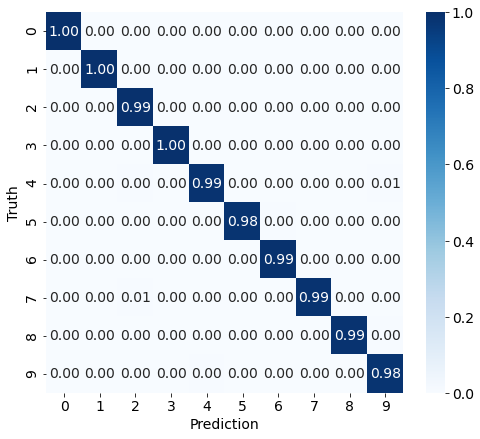

In [21]:
cmx = np.array(confusion_matrix(testY, predY))

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.rcParams["font.size"]=14
plt.figure(figsize=(8,7))
sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1)
plt.ylabel("Truth")
plt.xlabel("Prediction")